In [4]:
import os
import arviz as az
import pandas as pd
import numpy as np
import xarray as xr
from statsmodels.tsa.deterministic import DeterministicProcess
import matplotlib.pyplot as plt

# from tqdm.notebook import tqdm 
# import tqdm as notebook_tqdm

import utils.globalsettings as gs

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [8, 5] # 12, 7
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [154]:
df_groups = pd.read_csv(os.path.join(gs.the_folders.DIR_DATA_CLEAN, "ES_groups.csv"), sep = ";", parse_dates=["Date"], index_col=['Date'])

# Melt df_groups to long format
df_groups_long = df_groups.melt(ignore_index=False, var_name="group", value_name="value")

# Split 'group' column into 'group' (^.*-.*-) and 'variable' (the rest until the end)
df_groups_long[["group", "variable"]] = df_groups_long["group"].str.extract(r"^(.*-.*-[^_]*)_(.*)$")
df_groups_long.reset_index(inplace=True, drop=True)

# Create 'group_idx' column factorizing 'group'
df_groups_long["group_idx"] = pd.factorize(df_groups_long["group"])[0]

# Extract unique combinations of group and group_idx
group_idx = df_groups_long[["group", "group_idx"]].drop_duplicates().sort_values("group_idx").reset_index(drop = True)

group_idx


,group,group_idx
0,booking-luxury-b2b,0
1,booking-luxury-b2c,1
2,booking-rest-b2b,2
3,booking-rest-b2c,3
4,dir_web-luxury-b2b,4
5,dir_web-luxury-b2c,5
6,dir_web-rest-b2b,6
7,dir_web-rest-b2c,7
8,resto_otas-luxury-b2b,8
9,resto_otas-luxury-b2c,9


# Data

In [266]:
df = pd.read_csv(os.path.join(gs.the_folders.DIR_DATA_CLEAN, "BASE0_ES.csv"), sep = ";", parse_dates=["Date"])

df['group'] = df['group'] - 1

# rename column 'group' as 'group_idx'
df = df.rename(columns={"group": "group_idx"})

# Join df and group_idx
df = df.join(group_idx.set_index("group_idx"), on = "group_idx")

# Suponiendo df es tu DataFrame y ya tiene las columnas 'idx_group' y 'group'
# Añadir variables de tendencia y estacionalidad Fourier
dp = DeterministicProcess(
    index=df['Date'].unique(),
    constant=True,  # intercepto
    order=1,        # tendencia lineal
    seasonal=False,  # efectos estacionales
    fourier = 2,
    period=365.25/7       # asumiendo datos semanales
)
df_fourier = dp.in_sample()

# Unir las nuevas variables de Fourier a tu DataFrame original
df = df.join(df_fourier, on = ['Date']).set_index(['Date'], drop = True)

In [267]:
df

,reservas,CRM_messages,Destination_ads,Display_Segmentado,Festivos,GRP_Competencia,Google_Hotel,Google_PMAX,Google_Search_Brand,Google_Search_Hybrid,...,rgi_metric,group_idx,relative_ari_metric,group,const,trend,"sin(1,52.18)","cos(1,52.18)","sin(2,52.18)","cos(2,52.18)"
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-01,0.000000,357081.0,4570.0,319284.0,1.0,437.46,243228.0,0.000000,171637.0,29962.0,...,0.939613,0,0.011295,booking-luxury-b2b,1.0,1.0,0.000000,1.000000,0.000000,1.000000
2021-11-08,0.000000,357081.0,3259.0,319284.0,0.0,774.75,282009.0,0.000000,184288.0,33713.0,...,0.939613,0,0.011295,booking-luxury-b2b,1.0,2.0,0.120126,0.992759,0.238513,0.971139
2021-11-15,0.000000,357081.0,2815.0,319284.0,0.0,605.71,265992.0,0.000000,188966.0,35726.0,...,0.939613,0,0.011295,booking-luxury-b2b,1.0,3.0,0.238513,0.971139,0.463258,0.886224
2021-11-22,0.000000,357081.0,3186.0,319284.0,0.0,318.09,281474.0,0.000000,178913.0,30036.0,...,0.939613,0,0.011295,booking-luxury-b2b,1.0,4.0,0.353445,0.935455,0.661263,0.750154
2021-11-29,0.000000,357081.0,4338.0,319284.0,0.0,87.29,308481.0,0.000000,158289.0,24600.0,...,0.939613,0,0.011295,booking-luxury-b2b,1.0,5.0,0.463258,0.886224,0.821100,0.570784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-30,1575.083333,558783.0,4268.0,4725306.0,1.0,118.59,274230.0,4743.408666,127402.0,59617.0,...,0.986718,11,0.014099,resto_otas-rest-b2c,1.0,105.0,-0.042993,0.999075,-0.085906,0.996303
2023-11-06,1652.904762,915236.0,4543.0,6712098.0,0.0,0.00,353533.0,4885.125344,138477.0,54088.0,...,1.063813,11,0.060004,resto_otas-rest-b2c,1.0,106.0,0.077334,0.997005,0.154204,0.988039
2023-11-13,2004.728571,724777.0,3910.0,6256757.0,0.0,0.00,316352.0,5217.111259,142544.0,43247.0,...,1.116057,11,0.051264,resto_otas-rest-b2c,1.0,107.0,0.196540,0.980496,0.385413,0.922744


## Scaling

In [261]:
class Scaler:
    """
    This class receives a pandas dataframe and scales all the numeric columns in
    it, dividing each numeric column by one in its 'mean', 'median', 'max'. 
    Non numeric columns are kept unchanged.
    Scaling factors are kept as attibutes.
    Methods: fit, transform, fit_transform and transform
    """
    def __init__(self, group_var = 'group', exclude_vars = [], method = 'mean'):
        self.group_var = group_var
        self.method = method
        self.scaling_factors = {}
        self.exclude_vars = exclude_vars + [self.group_var]
        self.groups = None
        self.numeric_columns = None

    def fit(self, df):
        self.groups = df[self.group_var].unique()
        self.numeric_columns = df.drop(self.exclude_vars, axis = 1).select_dtypes(include=[np.number]).columns

        for group in self.groups:
            if self.method == 'mean':
                self.scaling_factors[group] = df.loc[df[self.group_var] == group, self.numeric_columns].mean()
            elif self.method == 'median':
                self.scaling_factors[group] = df.loc[df[self.group_var] == group, self.numeric_columns].median()
            elif self.method == 'max':
                self.scaling_factors[group] = df.loc[df[self.group_var] == group, self.numeric_columns].max()
            else:
                raise ValueError('method must be "mean", "median" or "max"')
        return self
    
    def transform(self, df):
        df_scaled = df.copy()
        for group in self.groups:
            df_scaled.loc[df_scaled[self.group_var] == group, self.numeric_columns] = df_scaled.loc[df_scaled[self.group_var] == group, self.numeric_columns] / self.scaling_factors[group]
        return df_scaled
    
    def fit_transform(self, df):
        return self.fit(df).transform(df)
    
    def inverse_transform(self, df_scaled):
        df = df_scaled.copy()
        for group in self.groups:
            df.loc[df[self.group_var] == group, self.numeric_columns] = df.loc[df[self.group_var] == group, self.numeric_columns] * self.scaling_factors[group]
        return df


In [268]:

scaler = Scaler(group_var = 'group', exclude_vars = ['group_idx'], method = 'mean')

df_scaled = scaler.fit_transform(df)


In [269]:
df_scaled

,reservas,CRM_messages,Destination_ads,Display_Segmentado,Festivos,GRP_Competencia,Google_Hotel,Google_PMAX,Google_Search_Brand,Google_Search_Hybrid,...,rgi_metric,group_idx,relative_ari_metric,group,const,trend,"sin(1,52.18)","cos(1,52.18)","sin(2,52.18)","cos(2,52.18)"
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-01,0.000000,0.662614,1.306879,0.081943,5.190476,0.861771,0.960562,0.000000,1.126631,0.699101,...,0.909556,0,0.581658,booking-luxury-b2b,1.0,0.018182,0.000000,24.354579,0.000000,27.268020
2021-11-08,0.000000,0.662614,0.931973,0.081943,0.000000,1.526213,1.113716,0.000000,1.209672,0.786623,...,0.909556,0,0.581658,booking-luxury-b2b,1.0,0.036364,13.124268,24.178219,13.862966,26.481049
2021-11-15,0.000000,0.662614,0.805003,0.081943,0.000000,1.193214,1.050462,0.000000,1.240379,0.833592,...,0.909556,0,0.581658,booking-luxury-b2b,1.0,0.054545,26.058462,23.651691,26.925745,24.165560
2021-11-22,0.000000,0.662614,0.911098,0.081943,0.000000,0.626619,1.111604,0.000000,1.174391,0.700828,...,0.909556,0,0.581658,booking-luxury-b2b,1.0,0.072727,38.615257,22.782623,38.434338,20.455207
2021-11-29,0.000000,0.662614,1.240534,0.081943,0.000000,0.171956,1.218260,0.000000,1.039014,0.573990,...,0.909556,0,0.581658,booking-luxury-b2b,1.0,0.090909,50.612798,21.583600,47.724456,15.564155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-30,1.119948,1.036901,1.220516,1.212728,5.190476,0.233615,1.082995,3.031355,0.836271,1.391039,...,0.955153,11,0.726051,resto_otas-rest-b2c,1.0,1.909091,-4.697137,24.332060,-4.993084,27.167217
2023-11-06,1.175283,1.698349,1.299158,1.722629,0.000000,0.000000,1.396181,3.121922,0.908967,1.262031,...,1.029782,11,3.089890,resto_otas-rest-b2c,1.0,1.927273,8.449010,24.281644,8.962737,26.941868
2023-11-13,1.425444,1.344926,1.118139,1.605768,0.000000,0.000000,1.249345,3.334083,0.935663,1.009079,...,1.080355,11,2.639848,resto_otas-rest-b2c,1.0,1.945455,21.472792,23.879562,22.401218,25.161403


In [270]:

scaler.scaling_factors


{'booking-luxury-b2b': reservas                      1.972477e-01
 CRM_messages                  5.388974e+05
 Destination_ads               3.496881e+03
 Display_Segmentado            3.896427e+06
 Festivos                      1.926606e-01
 GRP_Competencia               5.076291e+02
 Google_Hotel                  2.532144e+05
 Google_PMAX                   1.564781e+03
 Google_Search_Brand           1.523454e+05
 Google_Search_Hybrid          4.285790e+04
 Google_Search_No_Brand        1.673759e+05
 Meta_branding                 2.176357e+05
 Meta_performance              4.783265e+05
 Metabuscadores                3.294145e+03
 OTA_Travel_ads                9.469037e+04
 Offline_competencia           1.224117e+06
 Offline_propio                2.147363e+03
 Prospecting                   7.875760e+06
 Retargeting                   4.333478e+05
 Seatback_cabeceros            1.829358e+01
 TikTok                        9.680741e+04
 Youtube                       3.688509e+01
 ari_metri

In [271]:
scaler.numeric_columns

Index(['reservas', 'CRM_messages', 'Destination_ads', 'Display_Segmentado',
       'Festivos', 'GRP_Competencia', 'Google_Hotel', 'Google_PMAX',
       'Google_Search_Brand', 'Google_Search_Hybrid', 'Google_Search_No_Brand',
       'Meta_branding', 'Meta_performance', 'Metabuscadores', 'OTA_Travel_ads',
       'Offline_competencia', 'Offline_propio', 'Prospecting', 'Retargeting',
       'Seatback_cabeceros', 'TikTok', 'Youtube', 'ari_metric', 'gri_index',
       'mpi_metric', 'nps_index', 'promocionblackfriday',
       'promociondiscovery_dollars', 'promociondoublenights',
       'promocionupto10-offseason', 'promocionupto10-season',
       'promocionupto15-offseason', 'promocionupto15-season',
       'promocionupto20-season', 'promocionupto25-season',
       'promocionupto30-season', 'promocionupto35-offseason',
       'promocionupto40-offseason', 'rgi_metric', 'relative_ari_metric',
       'const', 'trend', 'sin(1,52.18)', 'cos(1,52.18)', 'sin(2,52.18)',
       'cos(2,52.18)'],
     

In [272]:
df2 = scaler.inverse_transform(df_scaled)

df2

,reservas,CRM_messages,Destination_ads,Display_Segmentado,Festivos,GRP_Competencia,Google_Hotel,Google_PMAX,Google_Search_Brand,Google_Search_Hybrid,...,rgi_metric,group_idx,relative_ari_metric,group,const,trend,"sin(1,52.18)","cos(1,52.18)","sin(2,52.18)","cos(2,52.18)"
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-01,0.000000,357081.0,4570.0,319284.0,1.0,437.46,243228.0,0.000000,171637.0,29962.0,...,0.939613,0,0.011295,booking-luxury-b2b,1.0,1.0,0.000000,1.000000,0.000000,1.000000
2021-11-08,0.000000,357081.0,3259.0,319284.0,0.0,774.75,282009.0,0.000000,184288.0,33713.0,...,0.939613,0,0.011295,booking-luxury-b2b,1.0,2.0,0.120126,0.992759,0.238513,0.971139
2021-11-15,0.000000,357081.0,2815.0,319284.0,0.0,605.71,265992.0,0.000000,188966.0,35726.0,...,0.939613,0,0.011295,booking-luxury-b2b,1.0,3.0,0.238513,0.971139,0.463258,0.886224
2021-11-22,0.000000,357081.0,3186.0,319284.0,0.0,318.09,281474.0,0.000000,178913.0,30036.0,...,0.939613,0,0.011295,booking-luxury-b2b,1.0,4.0,0.353445,0.935455,0.661263,0.750154
2021-11-29,0.000000,357081.0,4338.0,319284.0,0.0,87.29,308481.0,0.000000,158289.0,24600.0,...,0.939613,0,0.011295,booking-luxury-b2b,1.0,5.0,0.463258,0.886224,0.821100,0.570784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-30,1575.083333,558783.0,4268.0,4725306.0,1.0,118.59,274230.0,4743.408666,127402.0,59617.0,...,0.986718,11,0.014099,resto_otas-rest-b2c,1.0,105.0,-0.042993,0.999075,-0.085906,0.996303
2023-11-06,1652.904762,915236.0,4543.0,6712098.0,0.0,0.00,353533.0,4885.125344,138477.0,54088.0,...,1.063813,11,0.060004,resto_otas-rest-b2c,1.0,106.0,0.077334,0.997005,0.154204,0.988039
2023-11-13,2004.728571,724777.0,3910.0,6256757.0,0.0,0.00,316352.0,5217.111259,142544.0,43247.0,...,1.116057,11,0.051264,resto_otas-rest-b2c,1.0,107.0,0.196540,0.980496,0.385413,0.922744


# xr.DataArray

In [280]:
lst_np_arrays = []
probe = df.drop(['group', 'group_idx'], axis = 1)
for idx_g in df['group_idx'].unique():
    lst_np_arrays.append(probe.loc[df['group_idx'] == idx_g, :].values)

np_array = np.stack(lst_np_arrays, axis = 2)

# Transformar el DataFrame a un xr.DataArray
data_array = xr.DataArray(
    np_array,
    coords = {
        'Date':      df.index.unique(), 
        'variable':  probe.columns,
        'group_idx': df['group_idx'].unique(), 
        'group':     ('group_idx', df['group'].unique())
        },
    dims = ['Date', 'variable', 'group_idx'],
    )

data_array 


<xarray.DataArray (Date: 109, variable: 46, group_idx: 12)>
array([[[0.00000000e+00, 4.40000000e+01, 1.11111111e+01, ...,
         7.00000000e+00, 9.00000000e+01, 1.45960000e+03],
        [3.57081000e+05, 3.57081000e+05, 3.57081000e+05, ...,
         3.57081000e+05, 3.57081000e+05, 3.57081000e+05],
        [4.57000000e+03, 4.57000000e+03, 4.57000000e+03, ...,
         4.57000000e+03, 4.57000000e+03, 4.57000000e+03],
        ...,
        [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00]],

       [[0.00000000e+00, 4.20000000e+01, 9.25000000e+00, ...,
         1.30000000e+01, 1.29032258e+02, 1.48300000e+03],
        [3.57081000e+05, 3.57081000e+05, 3.57081000e+05, ...,
         3.57081000e+05, 3.57081000e+05, 3.57081000e+05],
        [3.25900000e+03, 3.25900000e+03, 3.25900000e+03, ...,
         3.25900000e+03, 3.25900000e+03, 3.25900000e+03],
...
        [9.49786070e-01, 9.49786070e-01, 9.49786070e-01, ...,
         9.49786070e-01, 9.49786070e-01, 9.49786070e-01],
        [5.94376157e-01, 5.94376157e-01, 5.94376157e-01, ...,
         5.94376157e-01, 5.94376157e-01, 5.94376157e-01],
        [8.04187158e-01, 8.04187158e-01, 8.04187158e-01, ...,
         8.04187158e-01, 8.04187158e-01, 8.04187158e-01]],

       [[0.00000000e+00, 6.90000000e+01, 6.93333333e+00, ...,
         1.20000000e+01, 1.18800000e+02, 2.06752222e+03],
        [5.23721000e+05, 5.23721000e+05, 5.23721000e+05, ...,
         5.23721000e+05, 5.23721000e+05, 5.23721000e+05],
        [1.78300000e+03, 1.78300000e+03, 1.78300000e+03, ...,
         1.78300000e+03, 1.78300000e+03, 1.78300000e+03],
        ...,
        [9.05320842e-01, 9.05320842e-01, 9.05320842e-01, ...,
         9.05320842e-01, 9.05320842e-01, 9.05320842e-01],
        [7.69030859e-01, 7.69030859e-01, 7.69030859e-01, ...,
         7.69030859e-01, 7.69030859e-01, 7.69030859e-01],
        [6.39211653e-01, 6.39211653e-01, 6.39211653e-01, ...,
         6.39211653e-01, 6.39211653e-01, 6.39211653e-01]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2021-11-01 2021-11-08 ... 2023-11-27
  * variable   (variable) object 'reservas' 'CRM_messages' ... 'cos(2,52.18)'
  * group_idx  (group_idx) int64 0 1 2 3 4 5 6 7 8 9 10 11
    group      (group_idx) object 'booking-luxury-b2b' ... 'resto_otas-rest-b2c'

In [274]:
data_array['group'].sel(group_idx = 3).values.reshape((1))[0]

'booking-rest-b2c'

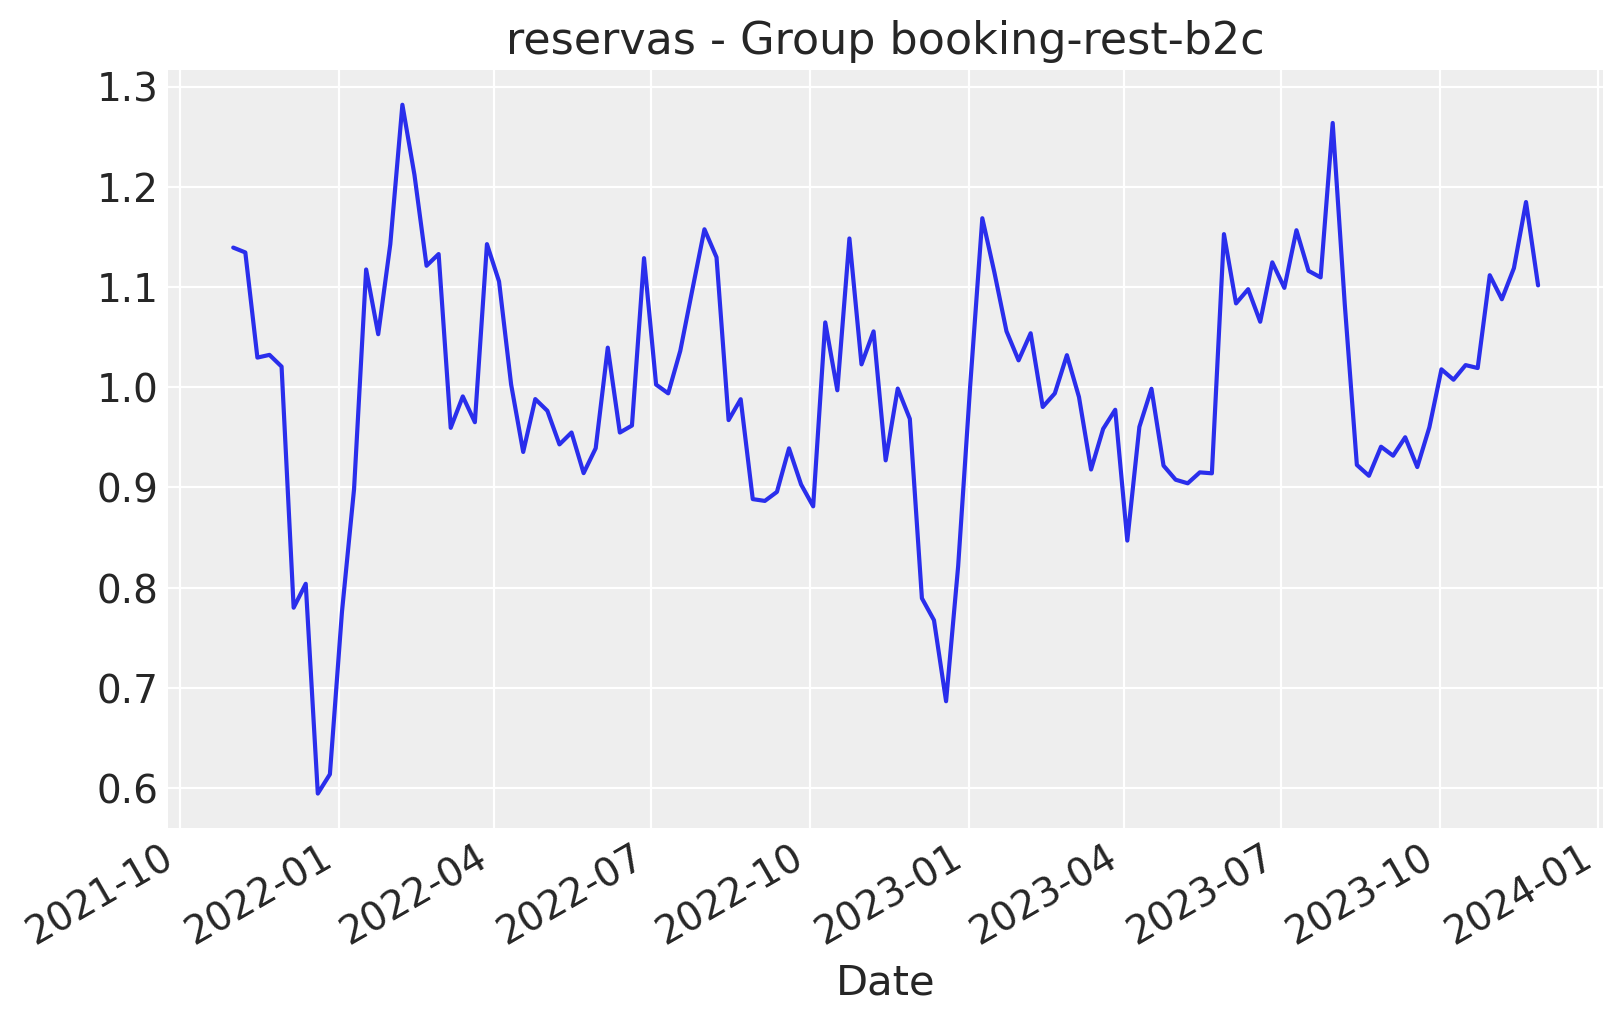

In [275]:
data_array.sel(variable = "reservas", group_idx = 3).plot()
plt.title(f"reservas - Group {data_array['group'].sel(group_idx = 3).values.reshape((1))[0]}");

<Axes: xlabel='Date'>

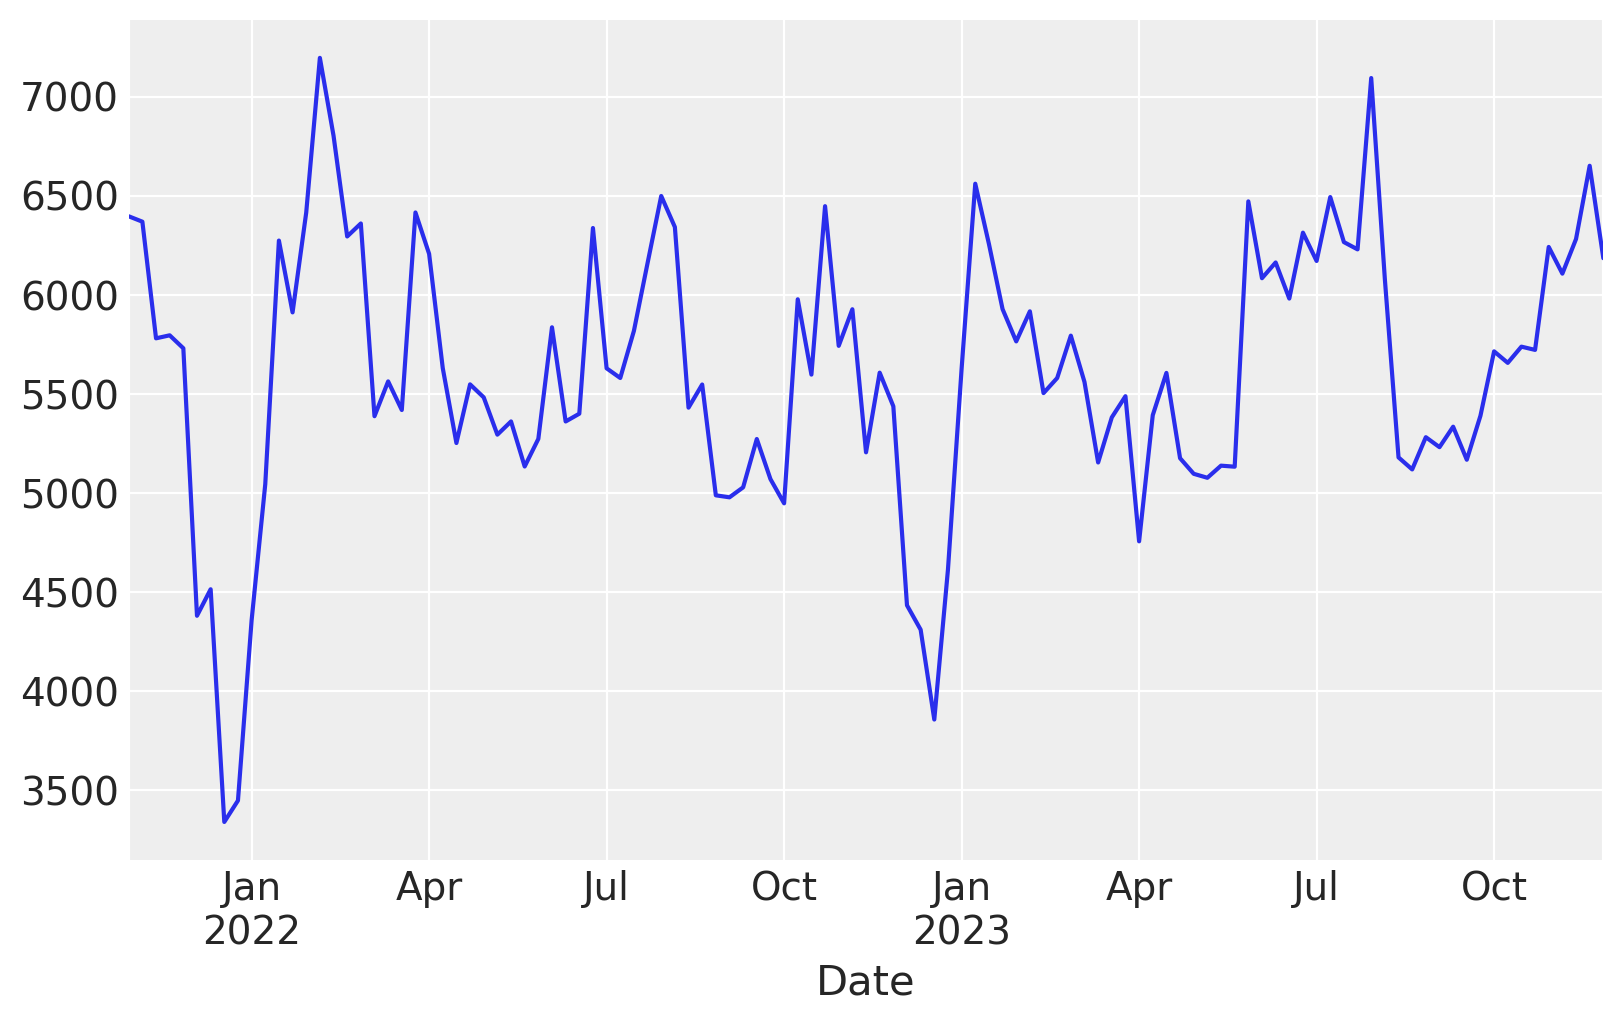

In [276]:
df.loc[df['group_idx'] == 3, 'reservas'].plot()

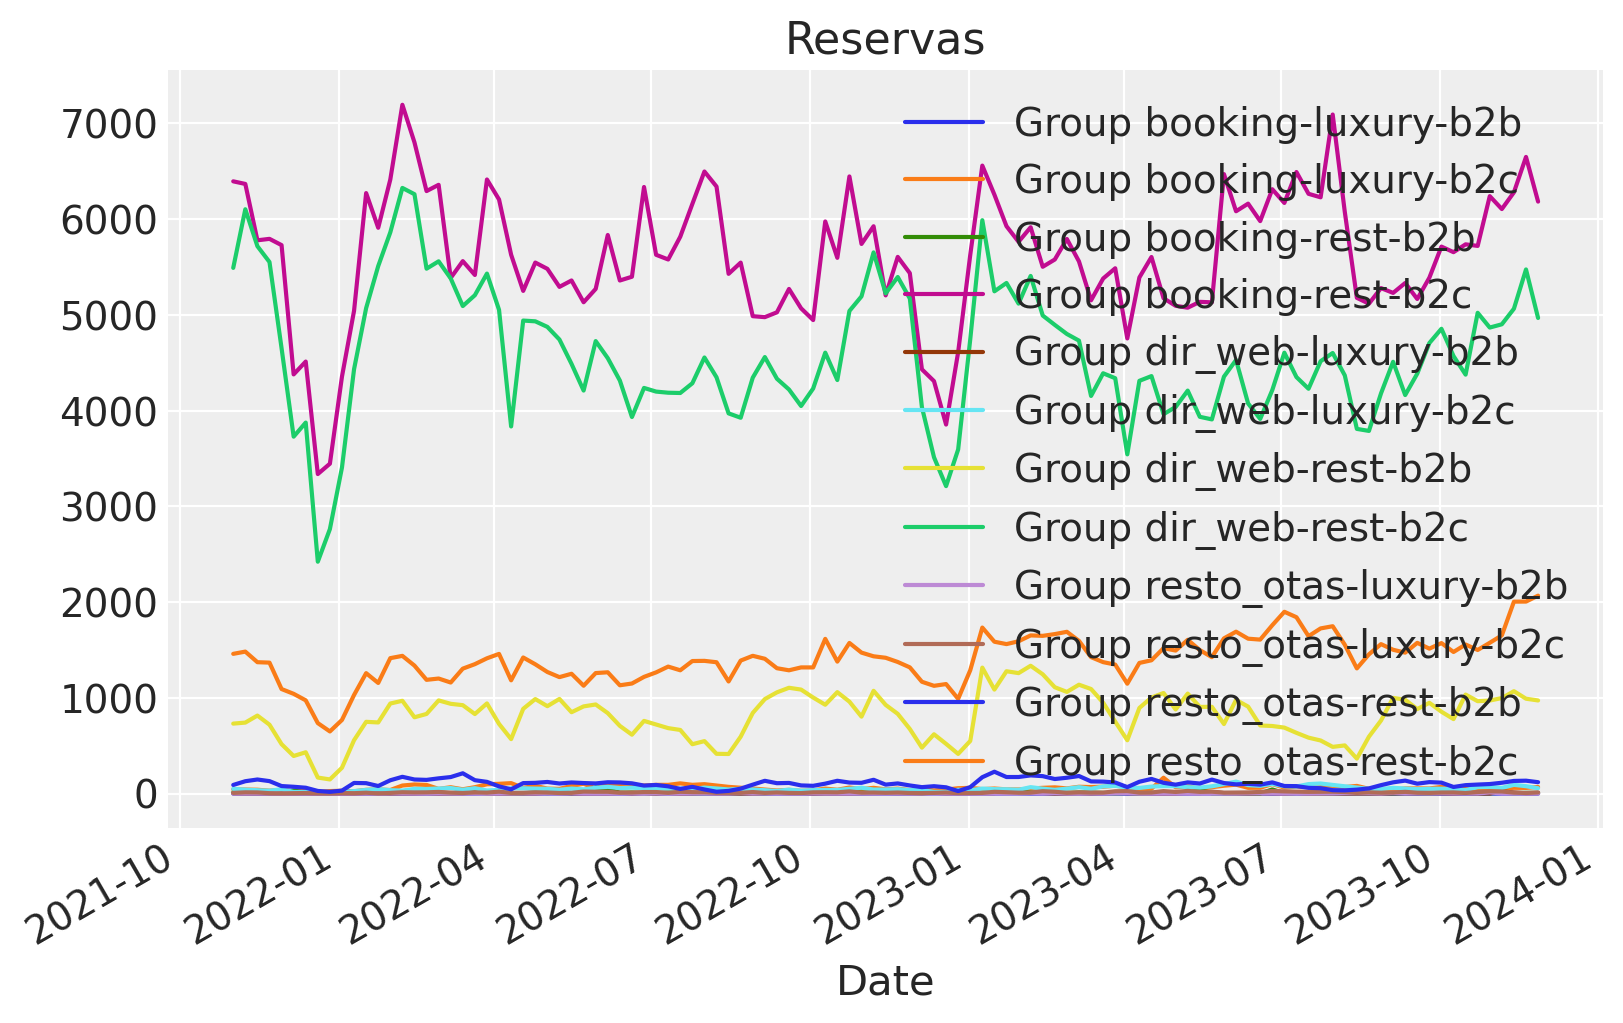

In [224]:
for g_idx in data_array['group_idx']:
    data_array.sel(variable = "reservas", group_idx = g_idx).plot(label = f"Group {data_array['group'].sel(group_idx = g_idx).values.reshape((1))[0]}")
plt.title("Reservas")
plt.legend()

In [225]:
data_array['variable']

<xarray.DataArray 'variable' (variable: 46)>
array(['reservas', 'CRM_messages', 'Destination_ads', 'Display_Segmentado',
       'Festivos', 'GRP_Competencia', 'Google_Hotel', 'Google_PMAX',
       'Google_Search_Brand', 'Google_Search_Hybrid', 'Google_Search_No_Brand',
       'Meta_branding', 'Meta_performance', 'Metabuscadores', 'OTA_Travel_ads',
       'Offline_competencia', 'Offline_propio', 'Prospecting', 'Retargeting',
       'Seatback_cabeceros', 'TikTok', 'Youtube', 'ari_metric', 'gri_index',
       'mpi_metric', 'nps_index', 'promocionblackfriday',
       'promociondiscovery_dollars', 'promociondoublenights',
       'promocionupto10-offseason', 'promocionupto10-season',
       'promocionupto15-offseason', 'promocionupto15-season',
       'promocionupto20-season', 'promocionupto25-season',
       'promocionupto30-season', 'promocionupto35-offseason',
       'promocionupto40-offseason', 'rgi_metric', 'relative_ari_metric',
       'const', 'trend', 'sin(1,52.18)', 'cos(1,52.18)', 'sin(2,52.18)',
       'cos(2,52.18)'], dtype=object)
Coordinates:
  * variable  (variable) object 'reservas' 'CRM_messages' ... 'cos(2,52.18)'

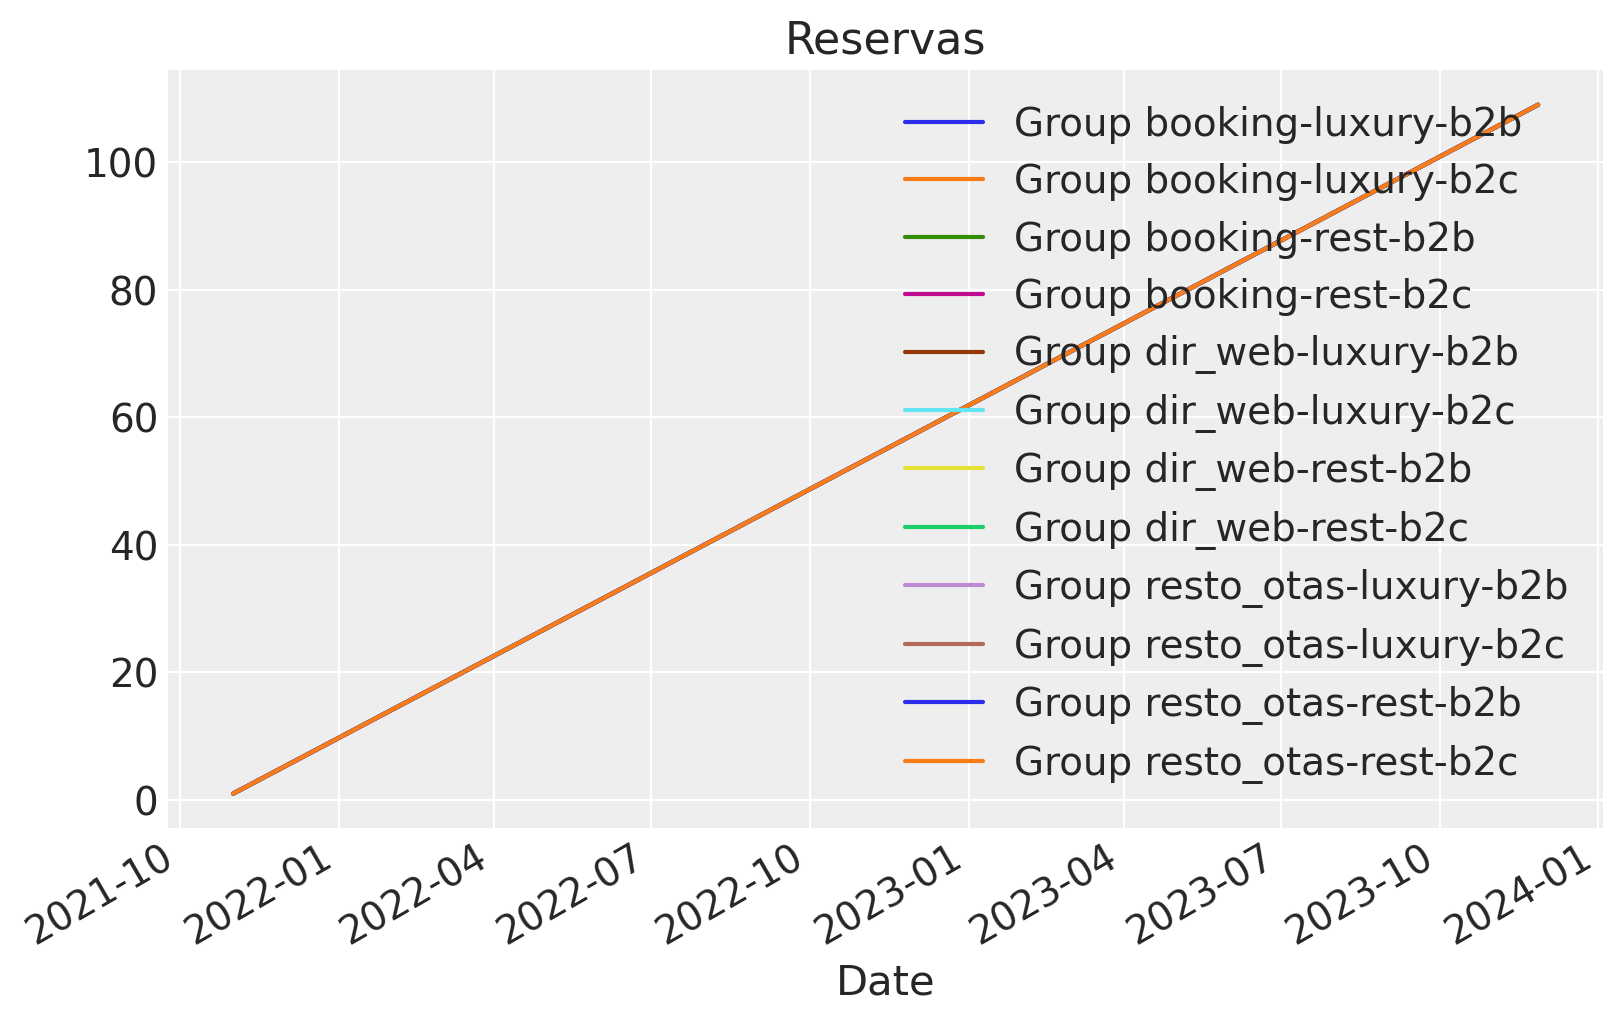

In [226]:
for g_idx in data_array['group_idx']:
    data_array.sel(variable = "trend", group_idx = g_idx).plot(label = f"Group {data_array['group'].sel(group_idx = g_idx).values.reshape((1))[0]}")
plt.title("Reservas")
plt.legend()

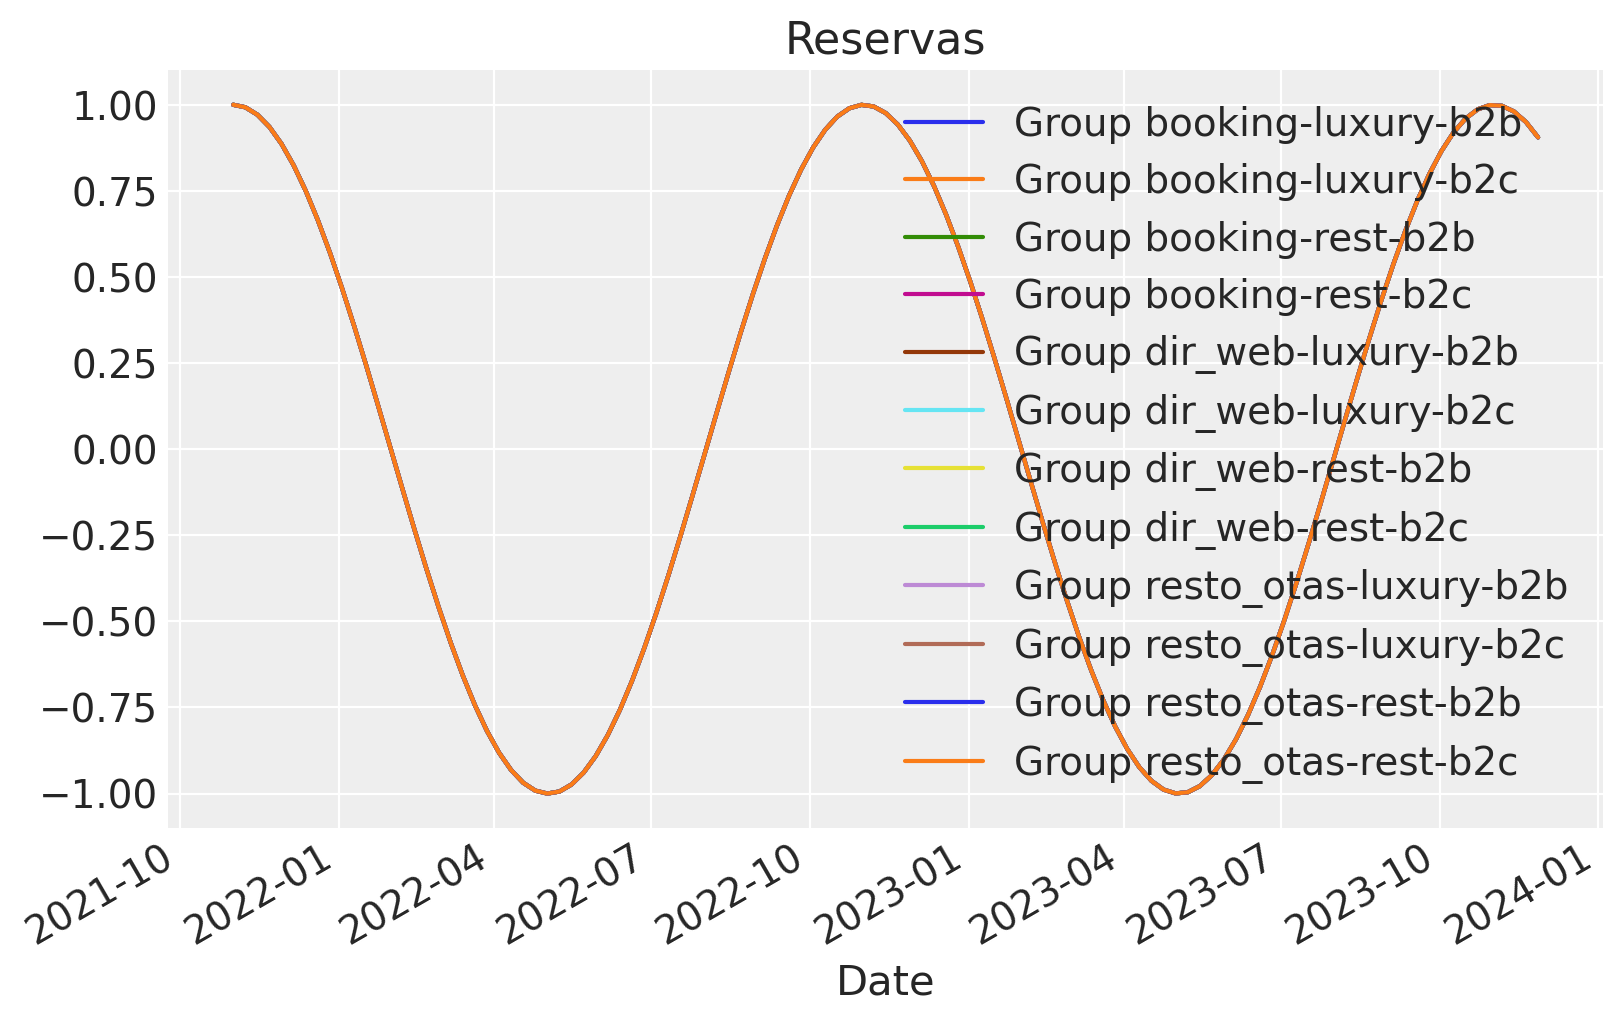

In [230]:
for g_idx in data_array['group_idx']:
    data_array.sel(variable = "cos(1,52.18)", group_idx = g_idx).plot(label = f"Group {data_array['group'].sel(group_idx = g_idx).values.reshape((1))[0]}")
plt.title("Reservas")
plt.legend()

<Axes: xlabel='Date'>

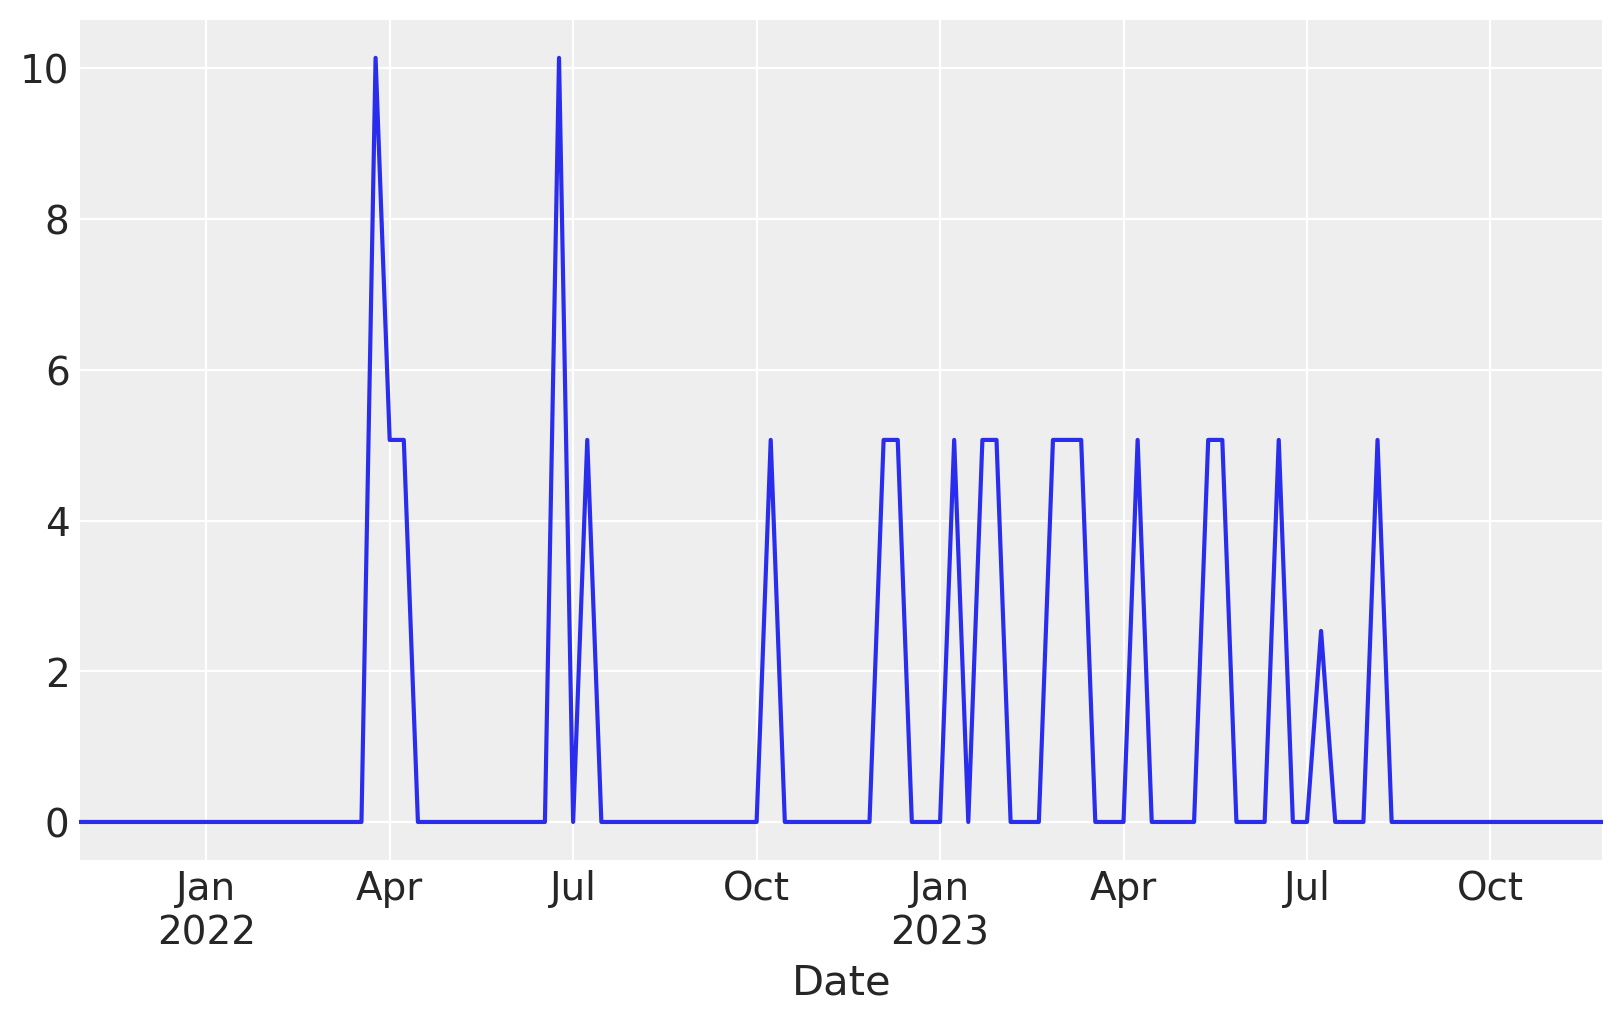

In [286]:
df_scaled.loc[df_scaled['group_idx'] == 0, 'reservas'].plot()

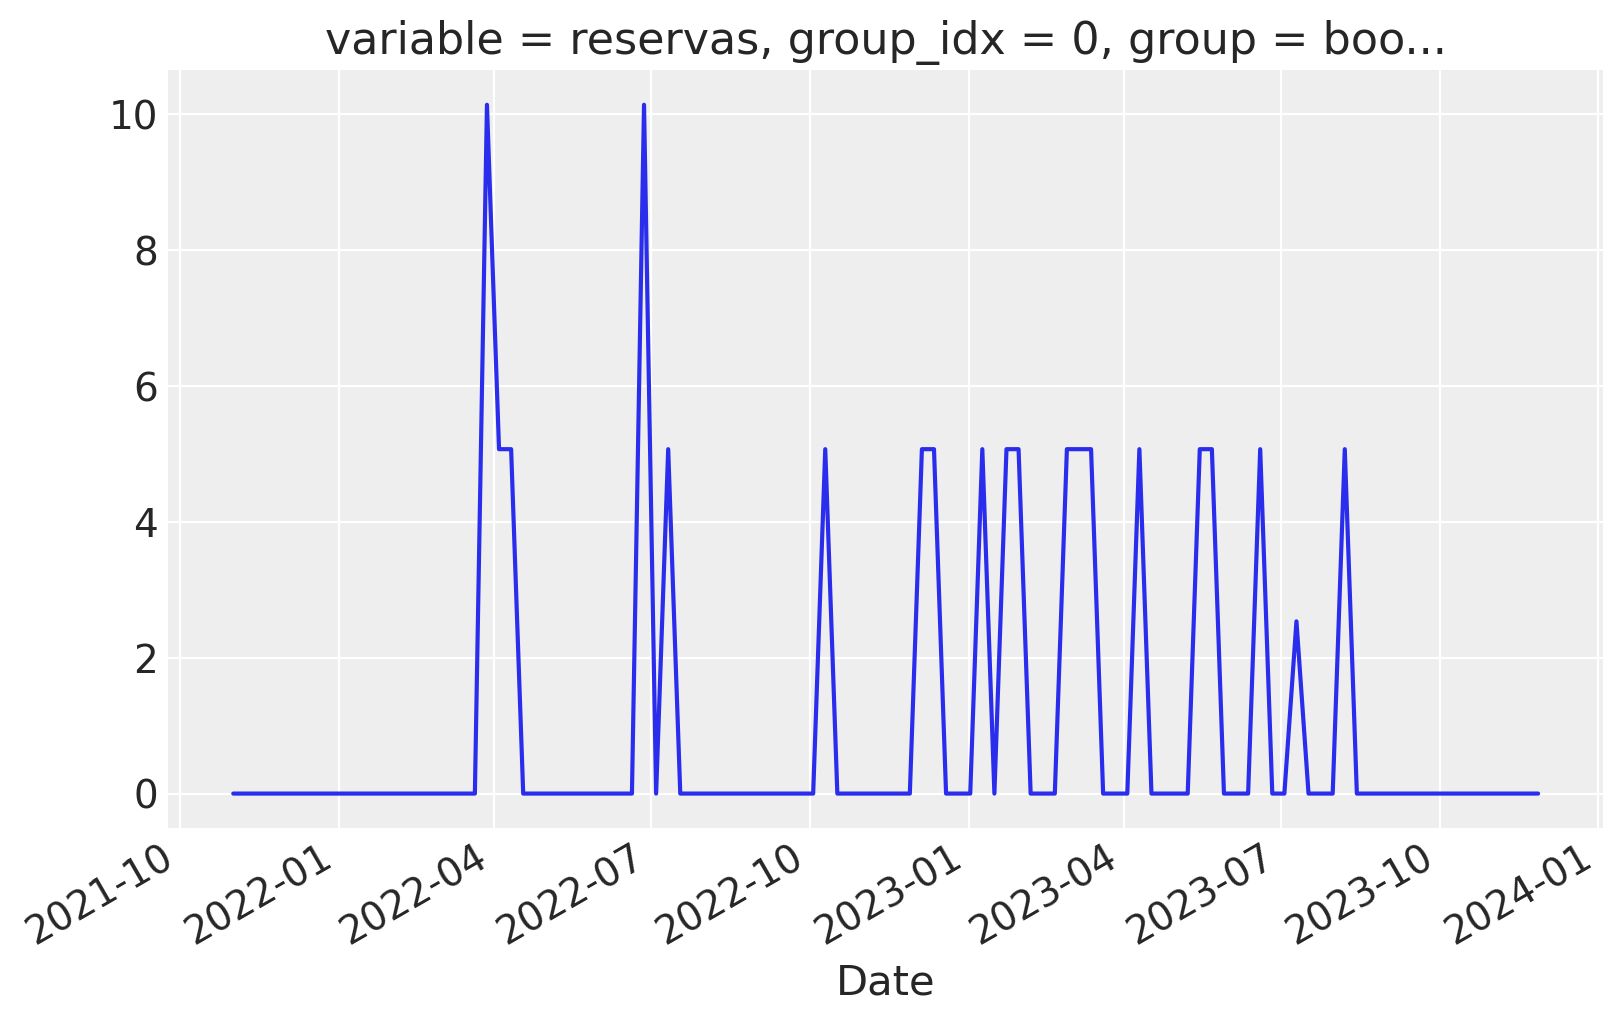

In [285]:
(data_array / data_array.mean(dim = 'Date')).sel(variable = 'reservas', group_idx = 0).plot()